# Refine tubule segmentation mask based on the GrabCut

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Define variables and get filenames

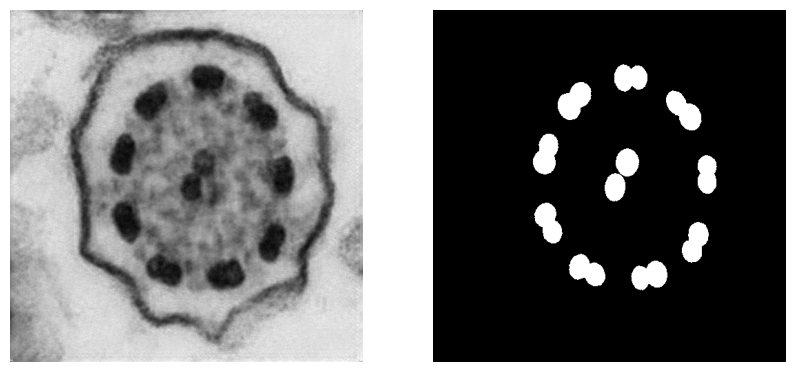

In [2]:
image_file = "../samples/sample1_refined.png"
mask_file = "../samples/sample1_mask.png"

extra_space_ratio = 0.2
contour_min_size = 10

image = cv2.imread(image_file)
mask_tubules = cv2.imread(mask_file)[:, :, 1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_tubules, cmap='gray')
plt.axis('off')

plt.show()


## Load and visualize current mask for tubules

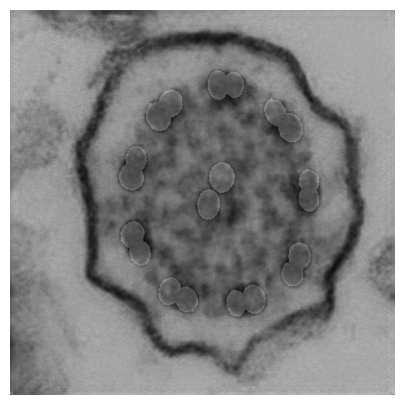

In [3]:

# Visualize the image and the mask with overlap
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.imshow(mask_tubules, alpha=0.25, cmap='gray')
plt.axis('off')
plt.show()

## Apply refine to example image

(-0.5, 511.5, 511.5, -0.5)

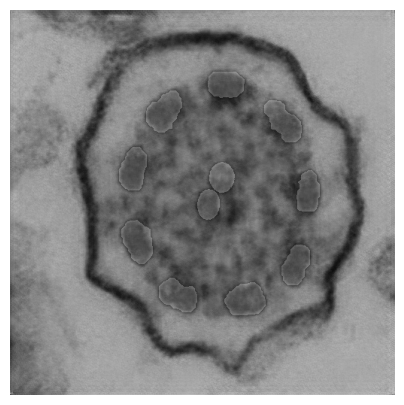

In [4]:
# resize the mask to the same size as the image
mask_tubules = cv2.resize(mask_tubules, (image.shape[1], image.shape[0]))
new_mask = np.zeros_like(mask_tubules, dtype=np.uint8)

contours, _ = cv2.findContours(mask_tubules, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for contour in contours:
    x1, y1, w, h = cv2.boundingRect(contour)

    half_extra_pixels = int(extra_space_ratio * max(w, h))
    new_x1 = x1 - 2*half_extra_pixels
    new_y1 = y1 - 2*half_extra_pixels
    new_x2 = x1 + w + 2*half_extra_pixels
    new_y2 = y1 + h + 2*half_extra_pixels

    crop = image[new_y1:new_y2, new_x1:new_x2]
    if crop.shape[0] < contour_min_size or crop.shape[1] < contour_min_size:
        cv2.drawContours(new_mask, [contour], -1, 1, thickness=cv2.FILLED)
    else:
        crop = cv2.GaussianBlur(crop, (3, 3), 0)

        crop_mask = mask_tubules[new_y1:new_y2, new_x1:new_x2] 
        mask_grabcut = np.zeros((crop.shape[:2]), dtype=np.uint8)

        backgroundModel = np.zeros((1, 65), np.float64)
        foregroundModel = np.zeros((1, 65), np.float64)
        rectangle = (half_extra_pixels, half_extra_pixels, w + 2 * half_extra_pixels, h + 2 * half_extra_pixels)

        ####
        mask_grabcut = cv2.rectangle(mask_grabcut, rectangle, 2, -1)
        mask_grabcut[np.where(crop_mask > 0)] = cv2.GC_PR_FGD

        cv2.grabCut(crop, mask_grabcut, None,  
                    backgroundModel, foregroundModel,
                    3, cv2.GC_INIT_WITH_MASK)

        new_crop_mask = np.where((mask_grabcut == 2)|(mask_grabcut == 0), 0, 1).astype('uint8')
        new_crop_mask_filtered = np.zeros_like(new_crop_mask)
        contours_new, _ = cv2.findContours(new_crop_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for new_contour in contours_new:
            x1, y1, w, h = cv2.boundingRect(new_contour)
            if x1 == 0 or y1 == 0 or x1 + w == new_crop_mask.shape[1] or y1 + h == new_crop_mask.shape[0]:
                continue
            else:
                cv2.drawContours(new_crop_mask_filtered, [new_contour], -1, 1, thickness=cv2.FILLED)            

        # if no object was added to the mask, add the original contour
        if np.sum(new_crop_mask_filtered) == 0: 
            cv2.drawContours(new_mask, [contour], -1, 1, thickness=cv2.FILLED)
        else:
            new_mask[new_y1:new_y2, new_x1:new_x2] += new_crop_mask_filtered

new_mask[np.where(new_mask > 0)] = 255

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.imshow(new_mask, alpha=0.25, cmap='gray')
plt.axis('off')

## Visualize details for comparison of refinement

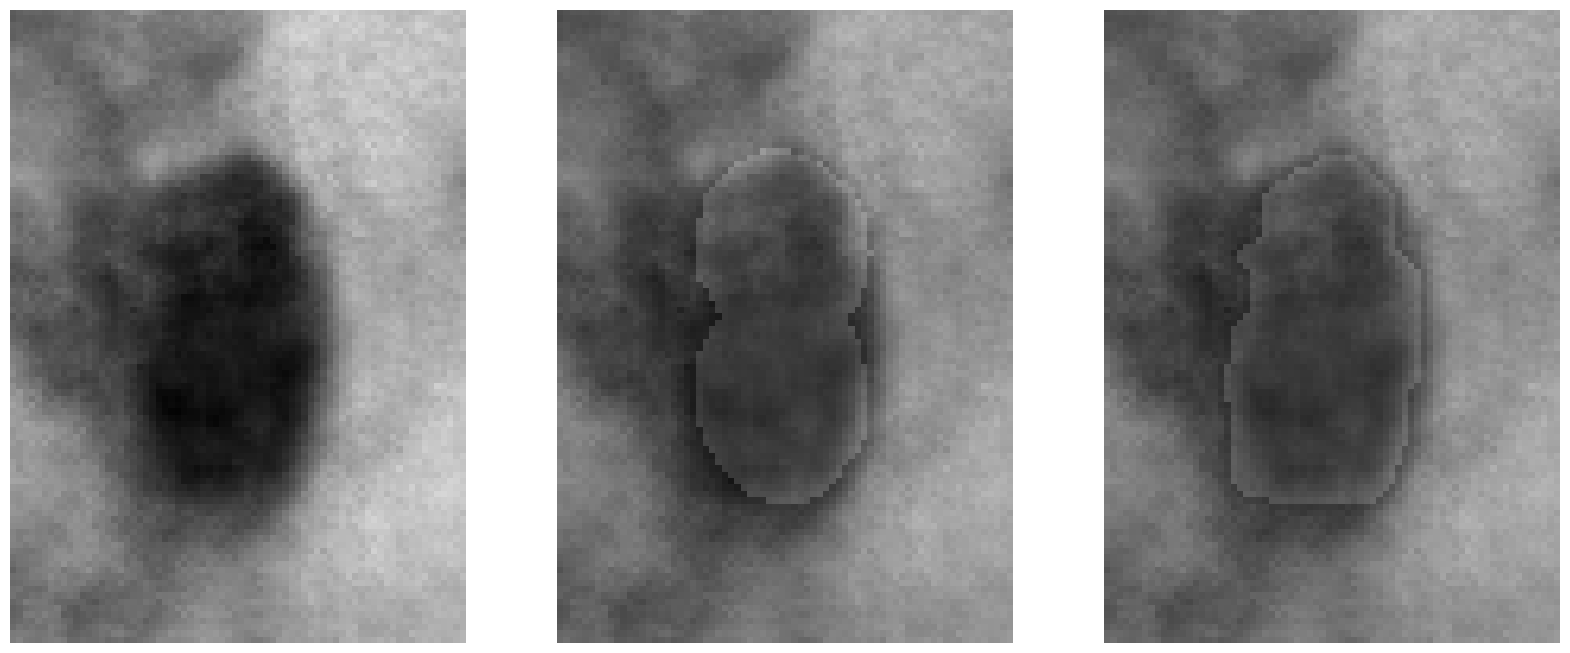

In [5]:
contour = contours[5]  # Specify contour to visualize
x1, y1, w, h = cv2.boundingRect(contour)

half_extra_pixels = int(extra_space_ratio * max(w, h))
new_x1 = max(0, x1 - 2*half_extra_pixels)
new_y1 = max(0, y1 - 2*half_extra_pixels)
new_x2 = x1 + w + 2*half_extra_pixels
new_y2 = y1 + h + 2*half_extra_pixels

crop = image[new_y1:new_y2, new_x1:new_x2]
old_mask_crop = mask_tubules[new_y1:new_y2, new_x1:new_x2]
new_mask_crop = new_mask[new_y1:new_y2, new_x1:new_x2]

plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.imshow(crop, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(crop)
plt.imshow(old_mask_crop, alpha=0.15, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(crop)
plt.imshow(new_mask_crop, alpha=0.15, cmap='gray')
plt.axis('off')

plt.show()